In [1]:
# Standard Python libraries
import time  # Time-related operations
import numpy as np  # Numerical operations
import copy  # Shallow and deep copy operations
import matplotlib.pyplot as plt  # Data visualization
import pandas as pd  # Data manipulation and analysis
import seaborn as sns  # Data visualization
import math  # Mathematical operations
from scipy.stats import norm  # Statistical functions

# More specific math-related imports
from math import sin, pi
from numpy import arange, asarray
from numpy.random import normal, uniform, random
from warnings import catch_warnings, simplefilter

# Machine learning libraries
from sklearn.gaussian_process import GaussianProcessRegressor  # Gaussian Process regression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier  # Random Forest models
from sklearn.metrics import accuracy_score

# Custom module imports
from autooed.utils.sampling import lhs  # Custom sampling module
import random  # Random number operations

# Data science and ML libraries
from sklearn import linear_model  # Linear models
from sklearn import ensemble  # Ensemble learning methods
from sklearn.tree import DecisionTreeRegressor  # Decision Tree regression
from sklearn.model_selection import GridSearchCV  # Grid search for hyperparameters

# Random number generation
from random import seed, randint
seed(1)  # Set the random seed

# Machine learning tools
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn import preprocessing  # Data preprocessing
from sklearn.pipeline import make_pipeline  # Creating ML pipelines
from sklearn.metrics import r2_score, mean_squared_error  # Evaluation metrics
from sklearn.tree import export_graphviz  # Tree visualization
from sklearn import svm  # Support Vector Machines
from sklearn.neural_network import MLPRegressor  # Multi-layer Perceptron regressor
from sklearn.neighbors import KNeighborsRegressor  # K-Nearest Neighbors regressor

# Data analysis and statistics
from numpy import cov  # Covariance calculation
from scipy.stats import pearsonr  # Pearson correlation
from scipy import ndimage, misc  # Image processing

# Miscellaneous
import os  # Operating system-related functions
import io  # Input/output operations
from sklearn.inspection import partial_dependence  # Partial dependence plots

# Chemistry and feature engineering
import pickle  # Serialization
import re  # Regular expressions
from rdkit import Chem  # Cheminformatics
from rdkit.Chem import AllChem, Descriptors  # RDKit functions
from chainer_chemistry.datasets.molnet import get_molnet_dataset  # Chemistry dataset retrieval

# More custom module imports
from autooed.utils.sampling import lhs  # Custom sampling module

# Additional libraries for data analysis and visualization
from sklearn.decomposition import PCA  # Principal Component Analysis
from sklearn.model_selection import train_test_split  # Data splitting
from datetime import datetime  # Date and time operations


In [2]:
## Define RF_feature_gen function:
## Input: R1, R2, .., R6 ratios of the monomers
## Output: Features as inputs to Black Box Random Forest (RF)

def RF_feature_gen(x):
    # Dictionary of molecular descriptors
    features = {
        'MolWt': Descriptors.MolWt,
        'HeavyAtomCount': Descriptors.HeavyAtomCount,
        'HeavyAtomMolWt': Descriptors.HeavyAtomMolWt,
        'NumHAcceptors': Descriptors.NumHAcceptors,
        'NumHDonors': Descriptors.NumHDonors,
        'NumHeteroatoms': Descriptors.NumHeteroatoms,
        'NumRotatableBonds': Descriptors.NumRotatableBonds,
        'NumValenceElectrons': Descriptors.NumValenceElectrons,
        'NumAromaticRings': Descriptors.NumAromaticRings,
        'NumSaturatedRings': Descriptors.NumSaturatedRings,
        'NumAliphaticRings': Descriptors.NumAliphaticRings,
        'NumRadicalElectrons': Descriptors.NumRadicalElectrons,
        'NumAliphaticCarbocycles': Descriptors.NumAliphaticCarbocycles,
        'NumAliphaticHeterocycles': Descriptors.NumAliphaticHeterocycles,
        'NumAromaticCarbocycles': Descriptors.NumAromaticCarbocycles,
        'NumAromaticHeterocycles': Descriptors.NumAromaticHeterocycles,
        'NumSaturatedCarbocycles': Descriptors.NumSaturatedCarbocycles,
        'NumSaturatedHeterocycles': Descriptors.NumSaturatedHeterocycles
    }

    # Modified Urethane Di-acrylate
    Oligoers_smiles = []
    RD_features = {}

    for f in features.keys():
        f = f + '_RD'
        RD_features[f] = []
        
    RD_SMILES = [
        'C=CC(=O)OCC(COC1=CC=CC=C1)O',
        'CC(C)CCCCCOC(=O)C=C',
        'C=CN1CCCC1=O',
        'C=CC(=O)O',
        'C=CC(=O)NCCO',
        'CC1(C2CCC1(C(C2)OC(=O)C=C)C)'
    ]

    for i, smiles in enumerate(RD_SMILES):
        if (i + 1) % 5000 == 0:
            print('Currently processed: {}/{}'.format(i+1, len(RD_SMILES)))

        m = AllChem.MolFromSmiles(smiles)

        for k, v in features.items():
            k = k + '_RD'
            try:
                RD_features[k].append(v(m))
            except:
                print("The feature is not available for {}".format(smiles))

    RD_features = pd.DataFrame(RD_features)
    X = np.array(x).reshape(-1, 1)
    X_features = X * RD_features

    return X_features

# Example of how to save the RD_features DataFrame to a CSV file:
# RD_features.to_csv('RD_features.csv', index=False)


In [4]:
# Read evaluated data
df_eval = pd.read_csv('new_evaluated_keep.csv',)
df_eval['Toughness(MJ/m3)'] = -df_eval['Toughness(MJ/m3)']
df_eval['Tensile_Strength(MPa)'] = -df_eval['Tensile_Strength(MPa)']

# Read initial data
df_init = pd.read_csv('Yuchao_20220816_keep.csv',)
df_init['Printability'] = df_init['Printability'].map(dict(Y=1, N=0))
x_eval = df_eval.iloc[:, 1:6]
x_init = df_init.iloc[:, 1:6]

# PCA Dimension Reduction
pca = PCA(n_components=2)
x_eval_pca = pca.fit_transform(x_eval)
x_init_pca = pca.fit_transform(x_init)

df_eval['pca1'] = x_eval_pca[:, 0]
df_eval['pca2'] = x_eval_pca[:, 1]

df_init['pca1'] = x_init_pca[:, 0]
df_init['pca2'] = x_init_pca[:, 1]

df_eval['initial'] = 'Eval.'
df_init['initial'] = 'Initial'

df = pd.concat([df_init, df_eval], axis=0)
# pick only the printable samples 
df_printable = df.loc[df['Printability']==1]


In [5]:
# Fit a Random Forest (RF) model to predict toughness and strength

# Prepare the data
Tensile_Strength_Mpa = np.asarray(df_printable['Tensile_Strength(MPa)']).reshape(1, -1)
Toughness = np.asarray(df_printable['Toughness(MJ/m3)']).reshape(1, -1)
Y = np.concatenate((Tensile_Strength_Mpa.T, Toughness.T), axis=1)

A_Ratio = np.asarray(df_printable['R1(HA)']).reshape(1, -1)
B_Ratio = np.asarray(df_printable['R2(IA)']).reshape(1, -1)
C_Ratio = np.asarray(df_printable['R3(NVP)']).reshape(1, -1)
D_Ratio = np.asarray(df_printable['R4(AA)']).reshape(1, -1)
E_Ratio = np.asarray(df_printable['R5(HEAA)']).reshape(1, -1)
F_Ratio = np.asarray(df_printable['R6(IBOA)']).reshape(1, -1)
X_ = np.concatenate((A_Ratio.T, B_Ratio.T, C_Ratio.T, D_Ratio.T, E_Ratio.T, F_Ratio.T), axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_, Y, test_size=0.2, random_state=6)

# Train the Random Forest regression model
regrRF = RandomForestRegressor(max_depth=6, random_state=9)
regrRF.fit(X_train, y_train)

# Calculate and print the R-squared scores for training and testing
r2_scoreRF_train = r2_score(y_train, regrRF.predict(X_train))
print("R-squared score for RF (training):", r2_scoreRF_train)

r2_scoreRF_test = r2_score(y_test, regrRF.predict(X_test))
print("R-squared score for RF (testing):", r2_scoreRF_test)


R-squared score for RF (training): 0.8446719897070746
R-squared score for RF (testing): 0.4080974716413965


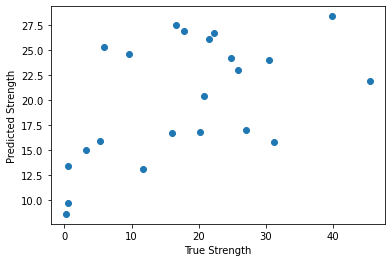

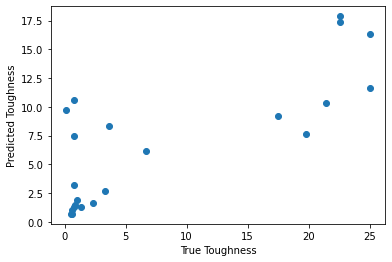

In [6]:
# Plot predicted strength vs. true strength
plt.scatter(y_test[:, 0].reshape(-1, 1), 
            regrRF.predict(X_test)[:, 0].reshape(-1, 1))
plt.xlabel('True Strength')
plt.ylabel('Predicted Strength')
plt.show()

# Plot predicted toughness vs. true toughness
plt.scatter(y_test[:, 1].reshape(-1, 1), 
            regrRF.predict(X_test)[:, 1].reshape(-1, 1))
plt.xlabel('True Toughness')
plt.ylabel('Predicted Toughness')
plt.show()


In [7]:
# Two RF classifiers: printability and Tg range performance on all data.
# Process printability
Printability = np.asarray(df['Printability']).reshape(1, -1).T
Y = Printability

# Process Tg (glass transition temperature)
Tg = np.asarray(df['Tg']).reshape(1, -1).T
Tg[np.isnan(Tg)] = 200
Tg_group = [1 if 10 < i < 60 else 0 for i in Tg]
Tg_group = np.array(Tg_group)

# Process other objectives
toughness = np.asarray(df['Toughness(MJ/m3)']).reshape(1, -1).T
toughness[np.isnan(toughness)] = 0
strength = np.asarray(df['Tensile_Strength(MPa)']).reshape(1, -1).T
strength[np.isnan(strength)] = 0
strain = np.asarray(df['Tensile_Strain_percentage']).reshape(1, -1).T
strain[np.isnan(strain)] = 0

# Process ratios of 6 monomers
A_Ratio = np.asarray(df['R1(HA)']).reshape(1, -1)
B_Ratio = np.asarray(df['R2(IA)']).reshape(1, -1)
C_Ratio = np.asarray(df['R3(NVP)']).reshape(1, -1)
D_Ratio = np.asarray(df['R4(AA)']).reshape(1, -1)
E_Ratio = np.asarray(df['R5(HEAA)']).reshape(1, -1)
F_Ratio = np.asarray(df['R6(IBOA)']).reshape(1, -1)
X_ = np.concatenate((A_Ratio.T, B_Ratio.T, C_Ratio.T, D_Ratio.T, E_Ratio.T), axis=1)
X0 = np.concatenate((A_Ratio.T, B_Ratio.T, C_Ratio.T, D_Ratio.T, E_Ratio.T, F_Ratio.T), axis=1)

# Load monomers descriptors
df_monomers = pd.read_csv('monomers_info.csv')
energy = np.array(-df_monomers['dft_sp_E_RB3LYP'])
pol_area = np.array(df_monomers['polar_surface_area'])
complexity = np.array(df_monomers['complexity'])
HAMW = np.array(df_monomers['HAMW'])
solubility = np.array(df_monomers['solubility_sqrt_MJperm3'])
solubility_d = np.array(df_monomers['solubility_dipole'])
solubility_h = np.array(df_monomers['solubility_h'])
solubility_p = np.array(df_monomers['solubility_p'])

# Multiply Ratios by their descriptors
X_energy = np.multiply(X0, energy)
X_complexity = np.multiply(X0, complexity)
X_HAMW = np.multiply(X0, HAMW)
X_solubility_d = np.multiply(X0, solubility_d)
X_solubility_h = np.multiply(X0, solubility_h)
X_solubility_p = np.multiply(X0, solubility_p)

# Combine all features
X = np.concatenate((X_energy, X_complexity, X_HAMW, X_solubility_d, X_solubility_h, X_solubility_p), axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=5)
Tg_group_train, Tg_group_test = train_test_split(Tg_group, test_size=0.2, random_state=9)

# Train Random Forest classifiers
RF_print = RandomForestClassifier(random_state=0, max_depth=5, n_estimators=50)
RF_print.fit(X_train, y_train.ravel())
Yhat = RF_print.predict(X_test)
acc = accuracy_score(y_test, Yhat)
print('Accuracy for Printability: %.3f' % acc)

RF_Tg = RandomForestClassifier(random_state=0, max_depth=5, n_estimators=50)
RF_Tg.fit(X_train, Tg_group_train.ravel())
Yhat = RF_Tg.predict(X_test)
acc = accuracy_score(Tg_group_test, Yhat)
print('Accuracy for Tg Grouping: %.3f' % acc)


Accuracy for Printability: 0.870
Accuracy for Tg Grouping: 0.783


In [9]:
print ("Done!!!!")

Done!!!!
